In [27]:
import phitech.helpers.sierra as pth_sierra
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
sierra_primary = pth_sierra.sierra_to_primary('./data/MES-202406-CME-USD.scid', '2024-06-04')
sierra_primary

header -> b'SCID8\x00\x00\x00(\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'


,timestamp,ts,price,side,action,size
0,3927484800090000,2024-06-04 00:00:00.090000,5437.50,B,F,2
1,3927484800090001,2024-06-04 00:00:00.090001,5437.50,B,F,1
2,3927484800090002,2024-06-04 00:00:00.090002,5437.50,B,F,1
3,3927484800090003,2024-06-04 00:00:00.090003,5437.50,B,F,1
4,3927484800090004,2024-06-04 00:00:00.090004,5437.50,B,F,1
...,...,...,...,...,...,...
344570,3927560397291000,2024-06-04 20:59:57.291000,5435.75,A,F,1
344571,3927560397291001,2024-06-04 20:59:57.291001,5435.75,A,F,1
344572,3927560397291002,2024-06-04 20:59:57.291002,5435.75,A,F,1
344573,3927560398341000,2024-06-04 20:59:58.341000,5435.50,A,F,3


In [29]:
bento_primary = pth_sierra.bento_to_primary("./data/bento_full.csv")
bento_primary

make ticks
loading data from -> ./data/bento_full.csv
bento data loaded -> (5727945, 9)
filter out market depth and unnecessary columns
make primary


,timestamp,ts,price,side,action,size
0,3928228140006379,2024-06-12 14:29:00.006379,5452.00,A,F,5
1,3928228140006381,2024-06-12 14:29:00.006381,5452.00,A,F,2
2,3928228140006381,2024-06-12 14:29:00.006381,5452.00,A,F,8
3,3928228140006824,2024-06-12 14:29:00.006824,5452.00,B,F,1
4,3928228140006834,2024-06-12 14:29:00.006834,5452.00,B,F,8
...,...,...,...,...,...,...
328384,3928262385439827,2024-06-12 23:59:45.439827,5436.25,A,F,1
328385,3928262385439827,2024-06-12 23:59:45.439827,5436.25,A,F,2
328386,3928262385439827,2024-06-12 23:59:45.439827,5436.25,A,F,1
328387,3928262385439827,2024-06-12 23:59:45.439827,5436.25,A,F,2


<Axes: >

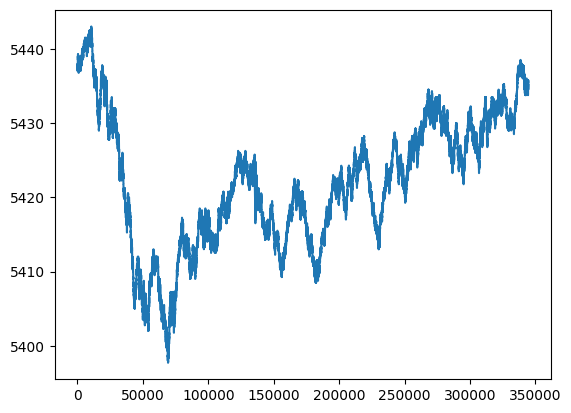

In [30]:
sierra_primary.price.plot()

<Axes: >

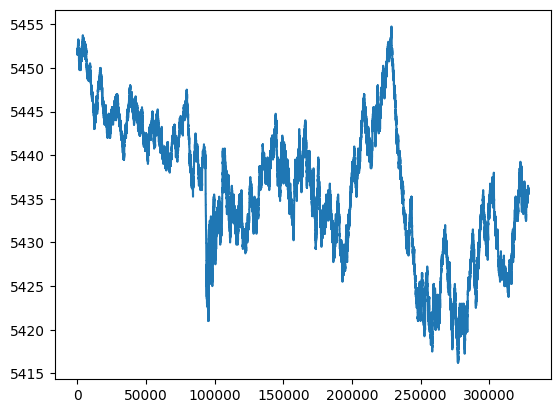

In [31]:
bento_primary.price.plot()

In [32]:
pth_sierra.primary_to_scid(
    sierra_primary,
    '/home/darchitect/wine-bottles/SierraChart/drive_c/SierraChart/Data/sierra-test.scid'
)

 100.00% 344575/344575... rate=5645.40 Hz, eta=0:00:00, total=0:01:00
Writing bytes to /home/darchitect/wine-bottles/SierraChart/drive_c/SierraChart/Data/sierra-test.scid
done.


In [33]:
pth_sierra.primary_to_scid(
    bento_primary,
    '/home/darchitect/wine-bottles/SierraChart/drive_c/SierraChart/Data/bento-test.scid'
)

 100.00% 328389/328389... rate=5822.39 Hz, eta=0:00:00, total=0:00:57
Writing bytes to /home/darchitect/wine-bottles/SierraChart/drive_c/SierraChart/Data/bento-test.scid
done.
